In [1]:
import pandas as pd
import numpy as np
import string, re, math

#Imports for plotting
import seaborn as sns
import matplotlib.pyplot as plt

#options
pd.options.display.max_rows = 50
import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly.express as px

## Cleaning CSV Files

**Read in Data**

In [3]:
df1 = pd.read_csv('data/glassdoor_ratings1_62.csv')
df2 = pd.read_csv('data/glassdoor_ratings2_37.csv')
df3 = pd.read_csv('data/glassdoor_ratings3_199.csv')
df4 = pd.read_csv('data/glassdoor_ratings5_797.csv')
df5 = pd.read_csv('data/glassdoor_ratings6_846.csv')
df6 = pd.read_csv('data/glassdoor_ratings7_453.csv')  
df7 = pd.read_csv('data/glassdoor_ratings8_873.csv') #scrape # 8
df8 = pd.read_csv('data/glassdoor_ratings_1to50.csv')
df9 = pd.read_csv('data/glassdoor_ratings_51to200.csv')
df10 = pd.read_csv('data/glassdoor_ratings_501to1k.csv')

#Combine data frames
data = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

print('Length of data set: ',len(data))
print('Number of duplicates: ', data['NAME'].duplicated().sum())

Length of data set:  5073
Number of duplicates:  1463


In [4]:
data.head()

,NAME,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION
0,Google,10000+ Employees,"Mountain View, CA",Internet,4.5,4.4,4.4,4.3,4.1,4.5,4.3,"See All 18,362 Reviews",NaN,NaN
1,Microsoft,10000+ Employees,"Redmond, WA",Computer Hardware & Software,4.4,4.4,4.3,4.1,4.0,4.1,4.1,"See All 29,389 Reviews",Our drive to change the world unites us!\n\nMi...,NaN
2,Apple,10000+ Employees,"Cupertino, CA",Computer Hardware & Software,4.3,4.4,4.3,3.7,3.7,4.3,3.8,"See All 20,851 Reviews",We’re a diverse collective of thinkers and doe...,NaN
3,US Air Force,10000+ Employees,"Washington, DC",Federal Agencies,4.2,4.2,4.0,3.3,3.4,4.3,4.2,"See All 16,600 Reviews",The mission of the US Department of the Air Fo...,NaN
4,Cisco Systems,10000+ Employees,"San Jose, CA",Computer Hardware & Software,4.2,4.3,4.3,4.2,3.8,4.1,3.9,"See All 21,804 Reviews","#WeAreCisco, where each person is unique, but ...",Mission: Cisco wants you to bring your uniquen...


### Preliminary Cleaning
 - Handle null values
 - reset indices 
 - drop duplicates

In [5]:
#Reset index to see all rows
data.reset_index(inplace=True)

In [6]:
#Drop null values from RATING_DI
print('NaN values dropped from RATING_DI: ', data.RATING_DI.isna().sum())
data.dropna(subset=['RATING_DI'], inplace=True)

#Drop null values from DESCRIPTION
print('NaN values dropped from DESCRIPTION: ', data.DESCRIPTION.isna().sum())
data.dropna(subset=['DESCRIPTION'], inplace=True)

NaN values dropped from RATING_DI:  487
NaN values dropped from DESCRIPTION:  166


In [7]:
#Drop duplicate companies by 'NAME' - drops size from 1941 to 1188
print('Duplicates dropped: ', data['NAME'].duplicated().sum())
data.drop_duplicates(subset='NAME', keep='last', inplace=True)
data = data.drop(['index'], axis=1)

Duplicates dropped:  1236


In [8]:
### RESET INDEX HERE TO NAME ### (easier searching?)
data = data.set_index('NAME')

In [9]:
#Check out dataframe
print('Shape: ', data.shape)
data.head(3)

Shape:  (3184, 13)


,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION
NAME,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,"See All 5,198 Reviews",We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,"See All 1,765 Reviews","Cornell is a private, Ivy League university re...",NaN
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,"See All 1,049 Reviews","Dude, let's hit the beach! And then we'll hit ...",NaN


## EDA and Feature Engineering
 - New features: Define target variable, Description length, 
 - Binning for simpler visualizatons: `RATING_DI`, `SIZE`, `HQ_STATE`
 - Cleaning: Number of reviews,
 
## EDA
 - Industry
 - inspecting overall trends: distribution, correlation, etc
 

### Clean up NUM_REVIEWS column
- return numbers only and drop companies with fewer than 100 reviews

In [10]:
def get_digits(s):
    #remove commas
    exclude = set(string.punctuation)
    s = ''.join(num for num in s if num not in exclude)

    #return digits only
    return s.split()[2]

#apply function to NUM_REVIEWS and change datatype to int
data['NUM_REVIEWS'] = data['NUM_REVIEWS'].apply(get_digits).astype(int)

In [11]:
#removing companies with too few reviews ### try changing this threshold to 50?
print('Number of companies dropped:', (data['NUM_REVIEWS'] < 100).sum())
data = data[(data['NUM_REVIEWS'] > 100)]

Number of companies dropped: 342


### Defining TARGET variable

Text(0.5, 1.0, 'Distribution of Class')

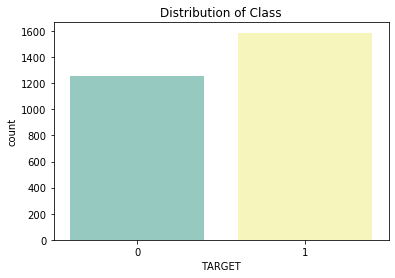

In [12]:
# New column for Target variable - companies with Diversity and Inclusion Rating over 4.0
data['TARGET'] = np.where(data['RATING_DI'] >= 4.0 , 1, 0)

# Checking for class imbalance
sns.countplot(data['TARGET'], palette='Set3').set_title('Distribution of Class')

### New features based on DECRIPTION

In [13]:
# change null values in MISSION and DESCRIPTION to ' '
data['MISSION'].fillna(' ', inplace=True)
data['DESCRIPTION'].fillna(' ', inplace=True)

#New column 'FULL_DESCRIPTION'
data['FULL_DESCRIPTION'] = np.add(data['DESCRIPTION'], data['MISSION'])

In [14]:
# New column for length of description
data['DESC_LEN'] = data['FULL_DESCRIPTION'].apply(lambda x: len(x))

### New feature based on RATING_DI

The rating scale used by Glassdoor.com is a scale from 1 to 5. Therefore, we will establish our **Target variable at 4.0**, since that would indicate an "A" rating on this scale.

In [15]:
# Checking average Diversity and Inclusion score / Overall score
print('data.RATING_DI.mean()')
print('data.RATING_OVERALL.mean()')

data.RATING_DI.mean()
data.RATING_OVERALL.mean()


In [16]:
#how many companies are above and below the threshold?
print('Percentage of companpies below threshold:', 
      (len(data[(data['RATING_DI'] <= 4.0)]) / (len(data)))*100)
print('Percentage of companpies above threshold:', 
      (len(data[(data['RATING_DI'] > 4.0)]) / (len(data)))*100)

Percentage of companpies below threshold: 53.53997886579782
Percentage of companpies above threshold: 46.46002113420219


In [17]:
#RATING_DI_BIN
#removing decimal value for data visualization ... ie 3.6 becomes 3
def truncate(f):
    return math.floor(f * 10 ** 0) / 10 ** 0

data['RATING_DI_BIN'] = data['RATING_DI'].apply(truncate).astype(int)

### New feature based on SIZE

In [18]:
## Assigning continuous variable to SIZE column

conditions = [ 
    data['SIZE'] == '10000+ Employees',
    data['SIZE'] == '5001 to 10000 Employees',
    data['SIZE'] == '1001 to 5000 Employees', 
    data['SIZE'] == '501 to 1000 Employees',
    ((data['SIZE'] == '201 to 500 Employees')|
     (data['SIZE'] == '51 to 200 Employees')|
     (data['SIZE'] == '1 to 50 Employees'))
]

## list of choices to be returned if said condition is True
choices = [
    5, #10k+
    4, #5001 to 10k Employees
    3, #1001 to 5k Employees 
    2, #500 to 1k
    1] #fewer than 500 Employees

data['SIZE_BIN'] = np.select(conditions, choices, default=None)

#Convert to float
data['SIZE_BIN'] = data['SIZE_BIN'].astype(float)

In [19]:
# ## Assigning continuous variable to SIZE column

# conditions = [ 
#     data['SIZE'] == '10000+ Employees',
#     data['SIZE'] == '5001 to 10000 Employees',
#     data['SIZE'] == '1001 to 5000 Employees', 
#     ((data['SIZE'] == '501 to 1000 Employees')|(data['SIZE'] == '201 to 500 Employees')| (data['SIZE'] == '51 to 200 Employees'))] 

# ## list of choices to be returned if said condition is True
# choices = [
#     4, #10k+
#     3, #5001 to 10k Employees
#     2, #1001 to 5k Employees 
#     1] #fewer than 1k Employees

# data['SIZE_BIN'] = np.select(conditions, choices, default=None)

# #Convert to float
# data['SIZE_BIN'] = data['SIZE_BIN'].astype(float)

In [20]:
data.SIZE_BIN.value_counts(normalize=True, sort=False)
#5: 10k+
#4: 5k-10k
#3: 1k-5k
#2: 500-1k, Under 500
#1: Under 500

5.0    0.256274
4.0    0.125486
3.0    0.299753
1.0    0.100742
2.0    0.217745
Name: SIZE_BIN, dtype: float64

In [21]:
data.SIZE.value_counts()

1001 to 5000 Employees     848
10000+ Employees           725
501 to 1000 Employees      616
5001 to 10000 Employees    355
51 to 200 Employees        220
1 to 50 Employees           57
Unknown                     10
201 to 500 Employees         8
Name: SIZE, dtype: int64

Text(0.5, 0, 'Company Size')

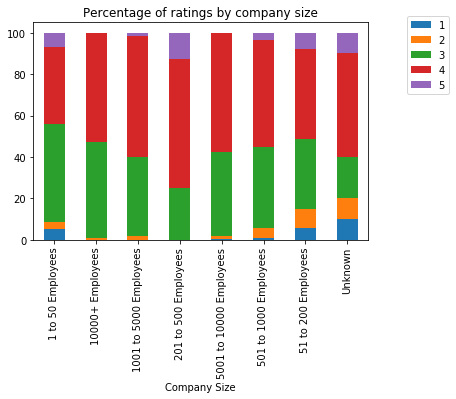

In [22]:
# Before binning: Size category grouped by rating
#Percentages (normalize = True)
x = data.groupby('SIZE')['RATING_DI_BIN'].value_counts(normalize=True).unstack() * 100

fig,ax = plt.subplots()
x.plot.bar(stacked=True,ax=ax,)

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Percentage of ratings by company size')
plt.xlabel('Company Size')

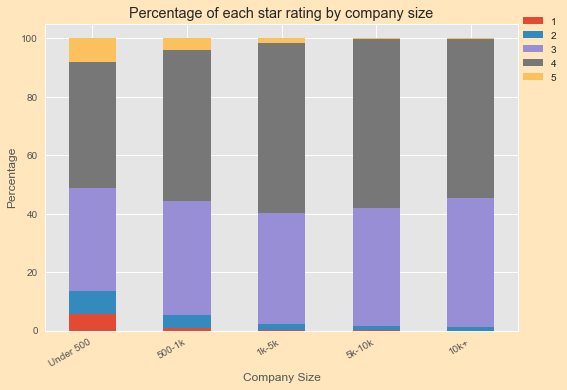

In [105]:
### After binning: Size category grouped by rating

# plt.style.use('seaborn-talk')
plt.style.use('ggplot')

x = data.groupby('SIZE_BIN')['RATING_DI_BIN'].value_counts(normalize=True).unstack() * 100

fig,ax = plt.subplots()

x.plot.bar(stacked=True,ax=ax,)

# Labels
plt.title('Percentage of each star rating by company size')
plt.ylabel('Percentage')
plt.xlabel('Company Size')
ax.set_xticklabels(('Under 500', '500-1k', '1k-5k', '5k-10k', '10k+'))
ax.legend(bbox_to_anchor=(1.1, 1.05))

#rotate xticks
fig.autofmt_xdate()

# Style
fig.patch.set_facecolor('moccasin')
fig.patch.set_alpha(0.9)
plt.tight_layout(pad=1)

# Uncomment below line to save plot
plt.savefig("images/Rating_v_Size2.png")

plt.show()



In [24]:
data.SIZE_BIN.value_counts(normalize=True)

3.0    0.299753
5.0    0.256274
2.0    0.217745
4.0    0.125486
1.0    0.100742
Name: SIZE_BIN, dtype: float64

In [25]:
##Size vs Rating DI
data.groupby('SIZE')['RATING_DI'].mean()

SIZE
1 to 50 Employees          3.796491
10000+ Employees           3.947172
1001 to 5000 Employees     4.021462
201 to 500 Employees       4.437500
5001 to 10000 Employees    3.994930
501 to 1000 Employees      3.954383
51 to 200 Employees        3.774091
Unknown                    3.830000
Name: RATING_DI, dtype: float64

In [124]:
##Size bin vs Rating DI
data.groupby('SIZE_BIN')['RATING_DI'].mean()

SIZE_BIN
1.0    3.798545
2.0    3.958070
3.0    4.022906
4.0    4.000000
5.0    3.963345
Name: RATING_DI, dtype: float64

In [26]:
data.SIZE.value_counts()

1001 to 5000 Employees     848
10000+ Employees           725
501 to 1000 Employees      616
5001 to 10000 Employees    355
51 to 200 Employees        220
1 to 50 Employees           57
Unknown                     10
201 to 500 Employees         8
Name: SIZE, dtype: int64

### New feature based on LOCATION_HQ

We decide to look at only US based companies in order to keep our focus of the project. To look at each state individually, we look at the last 4 characters in `LOCATION_HQ` to determine which companies are US based. Locations in the US are labeled with by city and state, other countries simply by country name.

In [27]:
data['HQ_STATE'] = data['LOCATION_HQ'].apply(lambda x: x[-6:])

In [28]:
# Inspect last characters of LOCATION_HQ to find companies with headquarters outside of the US
data['HQ_STATE'] = data['LOCATION_HQ'].apply(lambda x: x[-2:])

# Check dataframe shape
data.shape #2800

(2839, 19)

In [29]:
# dropping 300 columns not in US
data = data[data['HQ_STATE'].str[0].str.isupper()]

# New dataframe shape
data.shape

(2584, 19)

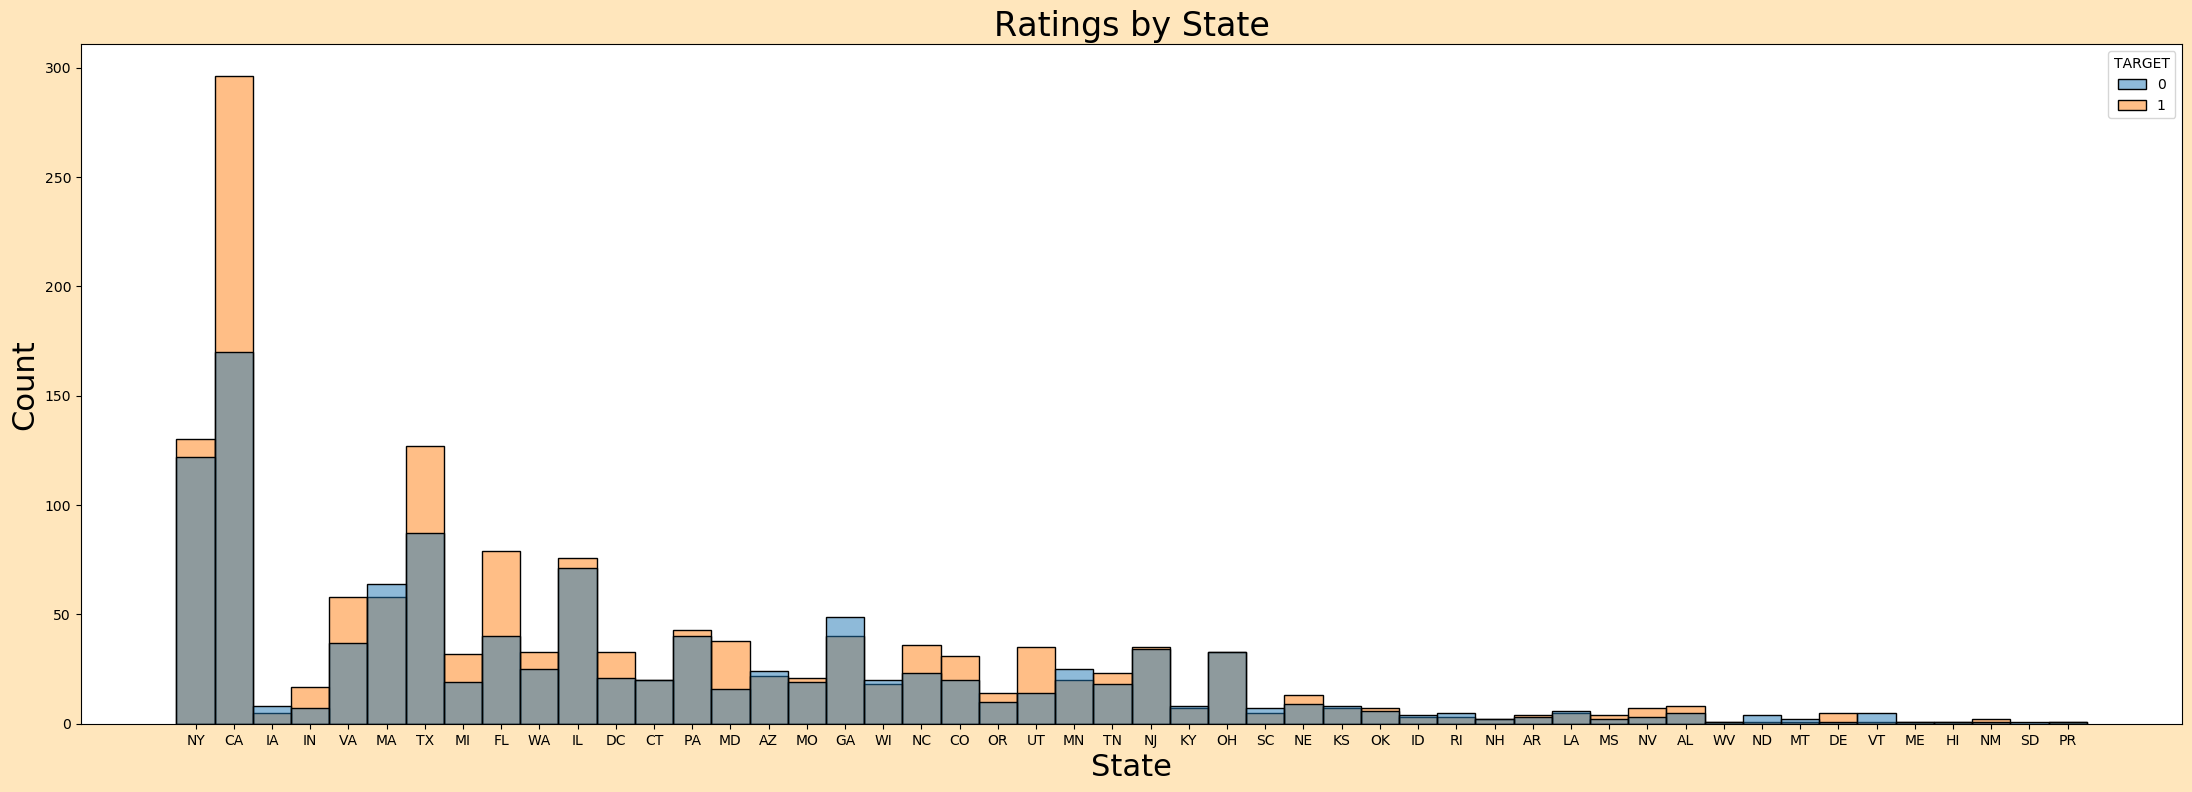

In [119]:
fig, axes = plt.subplots(figsize=(22, 8))

plt.style.use('default')

sns.histplot(data = data, x="HQ_STATE", hue = "TARGET")

# Labels
plt.title('Ratings by State', fontsize=24)
plt.xlabel('State', fontsize=22)
plt.ylabel('Count', fontsize=22)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# Rotate xticks
#fig.autofmt_xdate()

# Style
fig.patch.set_facecolor('moccasin')
fig.patch.set_alpha(0.9)
plt.tight_layout(pad=1)

# Uncomment below line to save plot
#plt.savefig("images/Rating_v_State.png")

plt.show()

### Industry

In [31]:
 data.groupby('INDUSTRY')['TARGET'].value_counts(sort=True).sort_values(ascending=False).unstack()

TARGET,0,1
INDUSTRY,,
Accounting,9.0,9.0
Advertising & Marketing,49.0,50.0
Aerospace & Defense,9.0,10.0
Airlines,1.0,4.0
Architectural & Engineering Services,9.0,13.0
...,...,...
Vehicle Dealers,4.0,11.0
Venture Capital & Private Equity,1.0,2.0
Veterinary Services,3.0,2.0


In [ ]:
### After binning size: Size category grouped by rating

# plt.style.use('seaborn-talk')
plt.style.use('ggplot')

x = data.groupby('SIZE_BIN')['RATING_DI_BIN'].value_counts(normalize=True).unstack() * 100

fig,ax = plt.subplots()

x.plot.bar(stacked=True,ax=ax,)

# Labels
plt.title('Percentage of each star rating by company size')
plt.ylabel('Percentage')
plt.xlabel('Company Size')
ax.set_xticklabels(('Under 500', '500-1k', '1k-5k', '5k-10k', '10k+'))
ax.legend(bbox_to_anchor=(1.1, 1.05))

#rotate xticks
fig.autofmt_xdate()

# Style
fig.patch.set_facecolor('moccasin')
fig.patch.set_alpha(0.9)
plt.tight_layout(pad=1)




TypeError: 'tuple' object is not callable

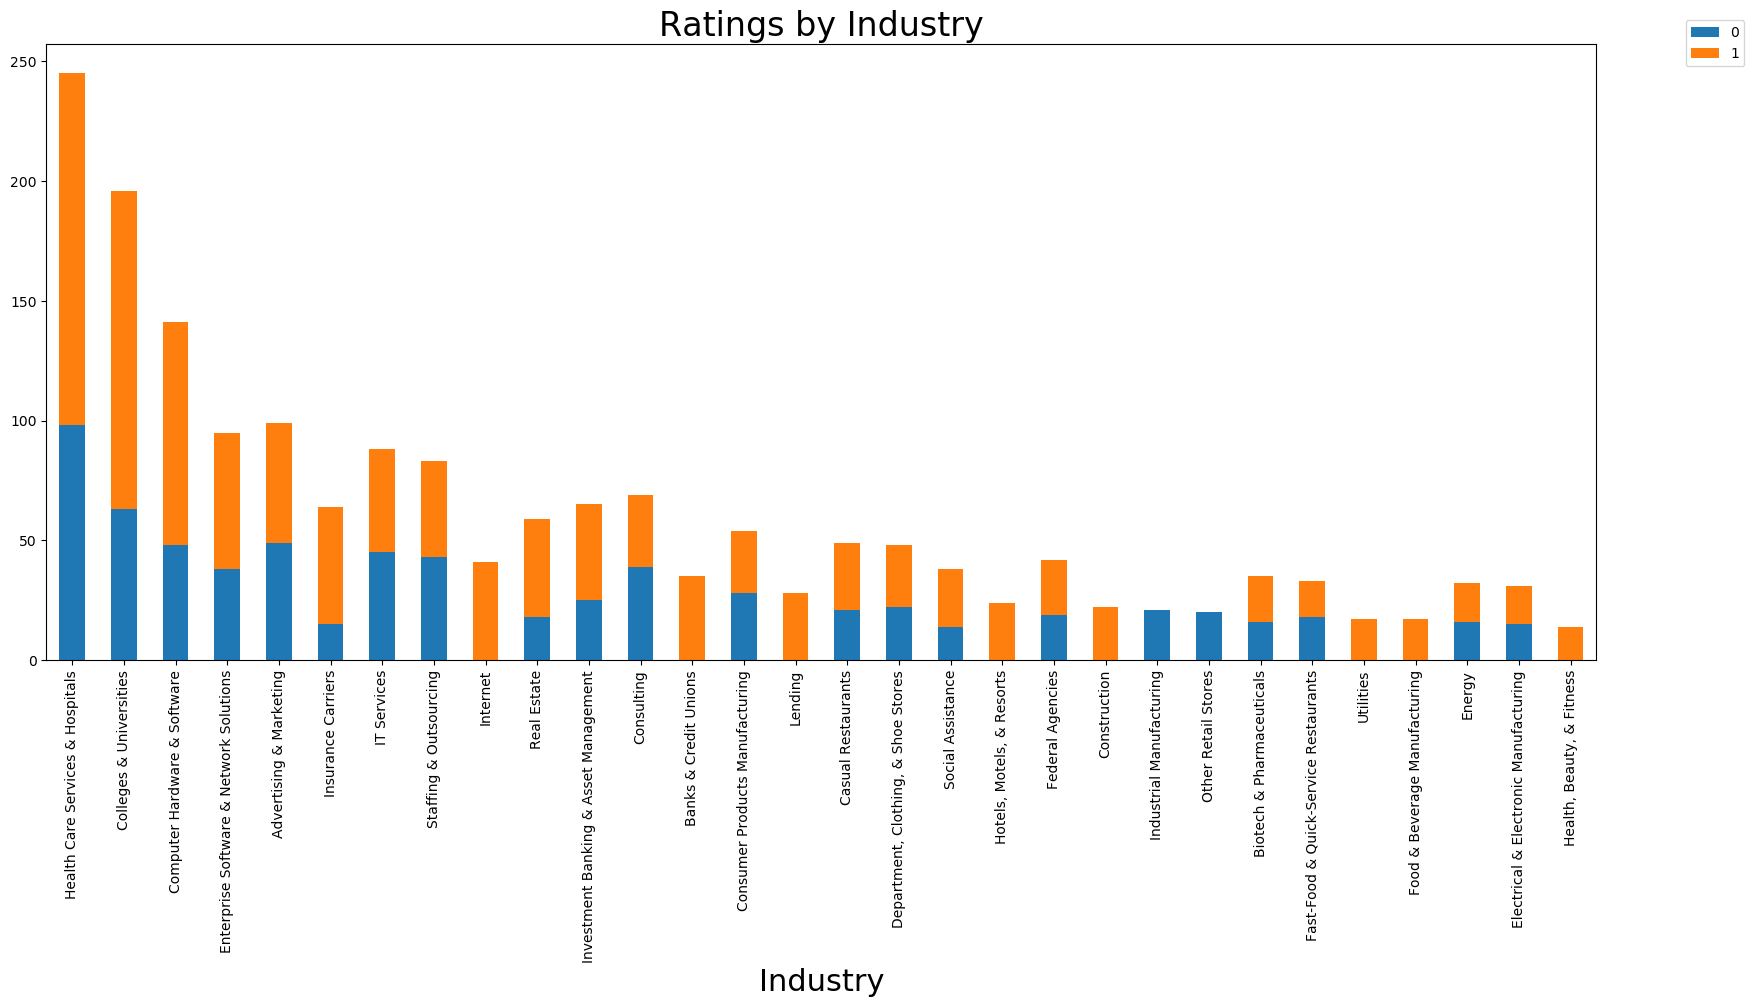

In [123]:
plt.style.use('default')

x =  data.groupby('INDUSTRY')['TARGET'].value_counts().sort_values(ascending=False).head(50).unstack()

fig,ax = plt.subplots(figsize=(20, 8))
x.plot.bar(stacked=True,ax=ax, label='label',orientation=u'vertical')
ax.legend(bbox_to_anchor=(1.1, 1.05))

#ax.invert_yaxis()
plt.title('Ratings by Industry', fontsize=24)
plt.xlabel('Industry', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.show()

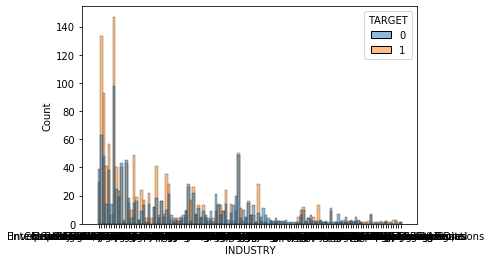

In [33]:
### adjust this plot size for readability
sns.histplot(data = data, x="INDUSTRY", hue = "TARGET", )
plt.show()

### Inspecting distribution and overall trends to catch any remaining trends

In [34]:
data.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,TARGET,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE
NAME,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,1,We work with leaders across sectors to tackle ...,1383,4,5.0,NY
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,1,"Cornell is a private, Ivy League university re...",618,4,5.0,NY
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,1,"Dude, let's hit the beach! And then we'll hit ...",654,4,4.0,CA


In [35]:
#Checking datatypes for plotting
print(data.info()) #Sanity Check

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, McKinsey & Company to Brooks Running
Data columns (total 19 columns):
SIZE                2584 non-null object
LOCATION_HQ         2584 non-null object
INDUSTRY            2584 non-null object
RATING_OVERALL      2584 non-null float64
RATING_DI           2584 non-null float64
RATING_CV           2584 non-null float64
RATING_WL           2584 non-null float64
RATING_SM           2584 non-null float64
RATING_CB           2584 non-null float64
RATING_CO           2584 non-null float64
NUM_REVIEWS         2584 non-null int64
DESCRIPTION         2584 non-null object
MISSION             2584 non-null object
TARGET              2584 non-null int64
FULL_DESCRIPTION    2584 non-null object
DESC_LEN            2584 non-null int64
RATING_DI_BIN       2584 non-null int64
SIZE_BIN            2574 non-null float64
HQ_STATE            2584 non-null object
dtypes: float64(8), int64(4), object(7)
memory usage: 483.8+ KB
None


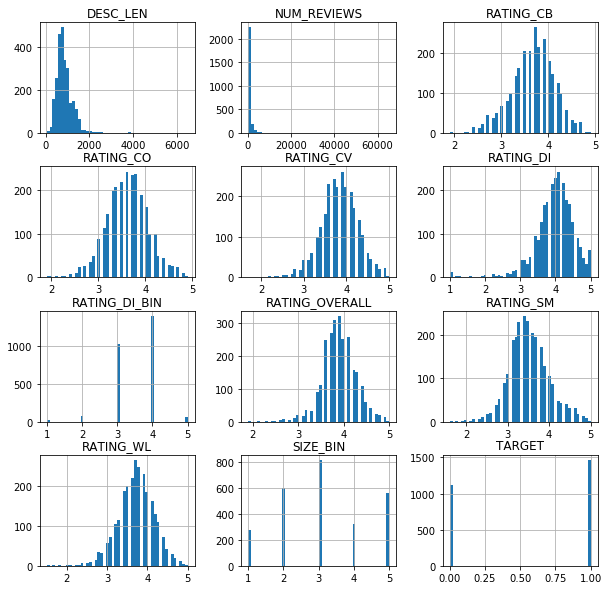

In [36]:
data.hist(bins=50, figsize=(10,10)) #sharex, sharey
plt.show()

*Rating distributions (above) are mostly normal*

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, McKinsey & Company to Brooks Running
Data columns (total 19 columns):
SIZE                2584 non-null object
LOCATION_HQ         2584 non-null object
INDUSTRY            2584 non-null object
RATING_OVERALL      2584 non-null float64
RATING_DI           2584 non-null float64
RATING_CV           2584 non-null float64
RATING_WL           2584 non-null float64
RATING_SM           2584 non-null float64
RATING_CB           2584 non-null float64
RATING_CO           2584 non-null float64
NUM_REVIEWS         2584 non-null int64
DESCRIPTION         2584 non-null object
MISSION             2584 non-null object
TARGET              2584 non-null int64
FULL_DESCRIPTION    2584 non-null object
DESC_LEN            2584 non-null int64
RATING_DI_BIN       2584 non-null int64
SIZE_BIN            2574 non-null float64
HQ_STATE            2584 non-null object
dtypes: float64(8), int64(4), object(7)
memory usage: 483.8+ KB


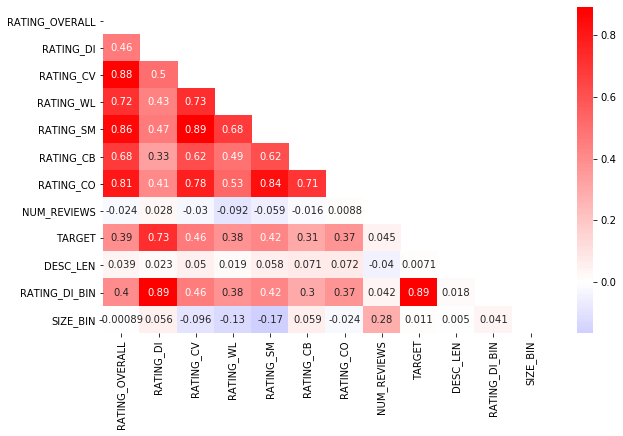

In [38]:
# Looking for any hidden correlations between continuous variables

fig, ax = plt.subplots(figsize=(10, 6))

corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

*No unusual correlations (above)*

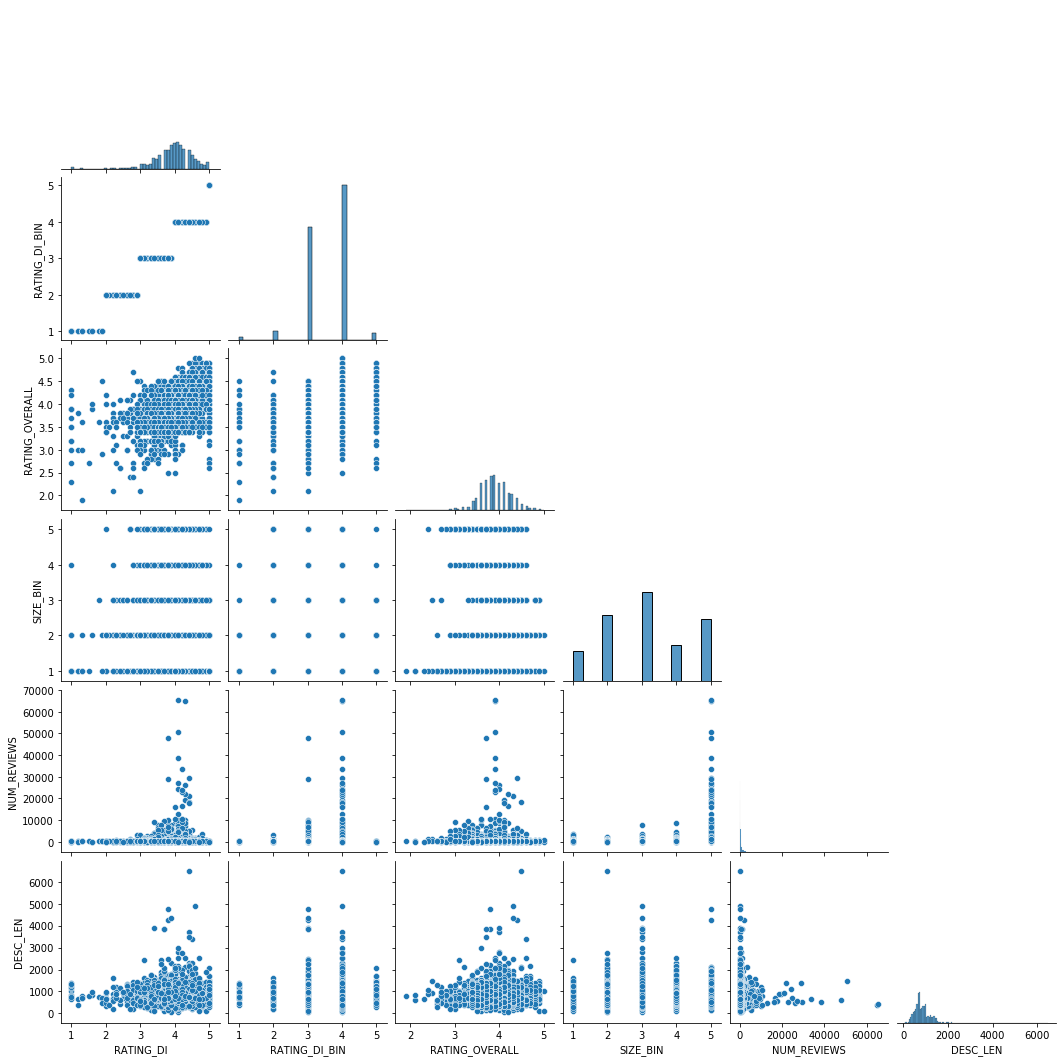

In [39]:
###find a better plot for this (bubbles?)
#continuous variables
sns.pairplot(data[['RATING_DI', 'RATING_DI_BIN', 'RATING_OVERALL', 'SIZE_BIN', 'SIZE', 'NUM_REVIEWS', 'DESC_LEN']], corner=True)


In [40]:
data.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,TARGET,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE
NAME,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,1,We work with leaders across sectors to tackle ...,1383,4,5.0,NY
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,1,"Cornell is a private, Ivy League university re...",618,4,5.0,NY
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,1,"Dude, let's hit the beach! And then we'll hit ...",654,4,4.0,CA


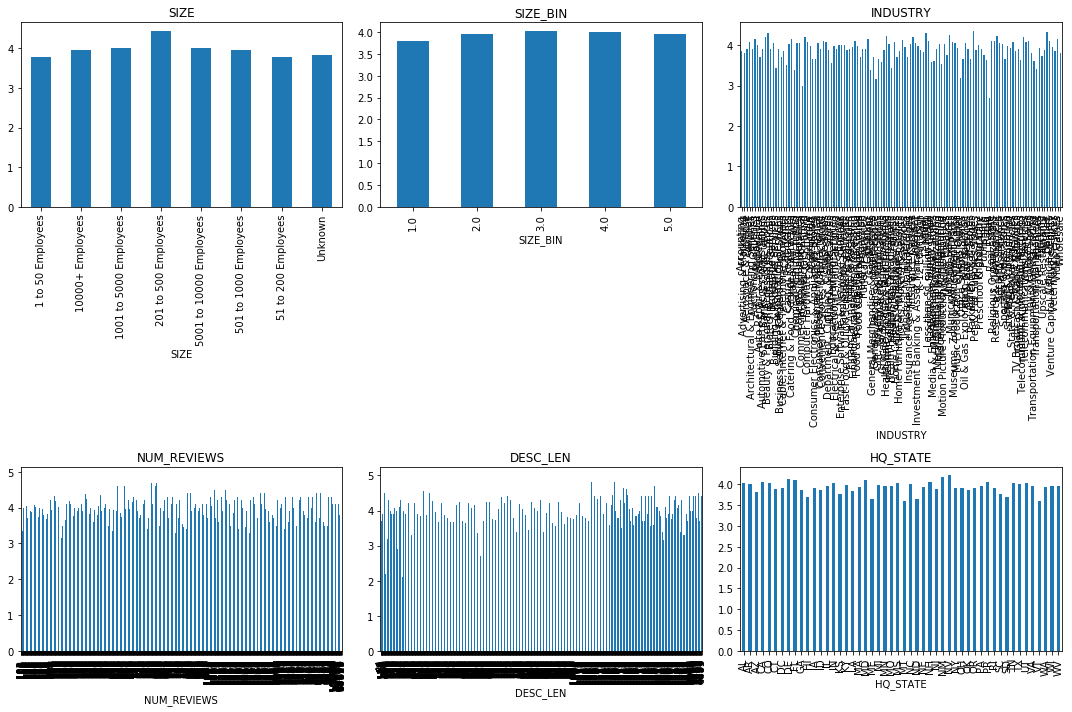

In [41]:
# Bar plots of categorical data
#zipcode explored later
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

categoricals = ['SIZE', 'SIZE_BIN', 'INDUSTRY', 'NUM_REVIEWS', 'DESC_LEN', 'HQ_STATE']

for col, ax in zip(categoricals, axes.flatten()):
    (data.groupby(col)               # group values together by column of interest
         .mean()['RATING_DI']        # take the mean of the saleprice for each group
         .plot
         .bar(ax=ax))                # create a bar graph on the ax    
    ax.set_title(col)                # Make the title the name of the column
fig.tight_layout()

## Saving final CSV

In [42]:
data.head(3) #Sanity Check

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,TARGET,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE
NAME,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,1,We work with leaders across sectors to tackle ...,1383,4,5.0,NY
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,1,"Cornell is a private, Ivy League university re...",618,4,5.0,NY
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,1,"Dude, let's hit the beach! And then we'll hit ...",654,4,4.0,CA


**Save updated CSV including all features**

In [43]:
data.to_csv('data/glassdoor_ratings_main.csv', index=False)